<a href="https://colab.research.google.com/github/Ankitaghavate/Ankitaghavate/blob/main/Copy_of_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
!pip install tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.listdir('/content/drive/MyDrive/HACKATHON')


['Copy of archive (4).zip']

In [ ]:
import zipfile

# Path to your file in Google Drive
zip_file = '/content/drive/MyDrive/archive (4).zip'
extracted_folder = '/content/audio_data/'

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print(f"Files extracted to {extracted_folder}")


Files extracted to /content/audio_data/


In [ ]:
import librosa
import numpy as np
import os

# Path to the folder where the audio files are extracted
audio_folder = '/content/audio_data/'  # adjust if necessary

# List all audio files in the folder
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]  # assuming .wav files

# Function to convert an audio file to MFCCs
def extract_mfcc(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Normalize MFCC
    mfcc = np.mean(mfcc, axis=1)

    return mfcc

# Extract MFCCs for all audio files
audio_data = []
for file in audio_files:
    file_path = os.path.join(audio_folder, file)
    mfcc_features = extract_mfcc(file_path)
    audio_data.append(mfcc_features)

# Convert the list into a NumPy array
audio_data = np.array(audio_data)

print(audio_data.shape)  # Check the shape of the extracted features


(0,)


In [ ]:
train_folder = '/content/audio_data/train'  # Adjust if necessary
print(os.listdir(train_folder))  # List files in the 'train' folder


['fake', 'real']


In [ ]:
import os
import librosa
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Paths for fake and real subfolders
fake_folder = '/content/audio_data/train/fake'
real_folder = '/content/audio_data/train/real'

# Function to extract MFCC from an audio file
def extract_mfcc(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Normalize MFCC by averaging over time frames
    mfcc = np.mean(mfcc, axis=1)

    return mfcc

# Function to process files and return the extracted features and labels
def process_audio_file(file_path, label):
    mfcc_features = extract_mfcc(file_path)
    return mfcc_features, label

# List all audio files in both 'fake' and 'real' folders
audio_data = []
labels = []  # Labels for classification (fake = 0, real = 1)

# Create a thread pool for parallel processing
with ThreadPoolExecutor() as executor:
    # Process fake audio files in parallel
    fake_files = [os.path.join(fake_folder, file) for file in os.listdir(fake_folder) if file.endswith('.wav')]
    fake_results = executor.map(lambda file: process_audio_file(file, 0), fake_files)

    # Process real audio files in parallel
    real_files = [os.path.join(real_folder, file) for file in os.listdir(real_folder) if file.endswith('.wav')]
    real_results = executor.map(lambda file: process_audio_file(file, 1), real_files)

    # Collect results
    for result in fake_results:
        audio_data.append(result[0])
        labels.append(result[1])

    for result in real_results:
        audio_data.append(result[0])
        labels.append(result[1])

# Convert the list into a NumPy array for audio data and labels
audio_data = np.array(audio_data)
labels = np.array(labels)

# Check the shape of the extracted features and labels
print(audio_data.shape)
print(labels.shape)


(13185, 13)
(13185,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)  # Check the shape of the splits


(10548, 13) (2637, 13)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the MFCC features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.968524838832006
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2159
           1       0.97      0.85      0.91       478

    accuracy                           0.97      2637
   macro avg       0.97      0.92      0.94      2637
weighted avg       0.97      0.97      0.97      2637



In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.968524838832006


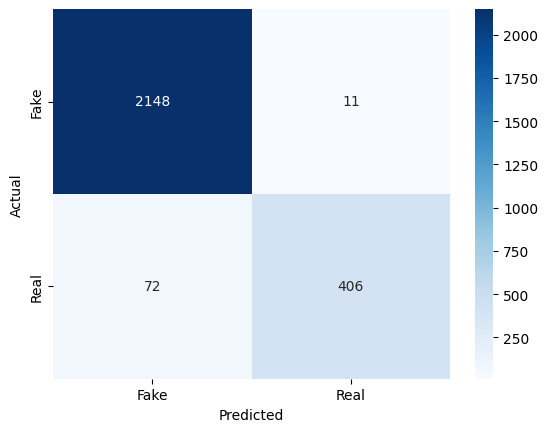

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential()

# Input layer (13 features)
model.add(Dense(64, input_dim=13, activation='relu'))
model.add(Dropout(0.3))  # Dropout for regularization

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,169 (28.00 KB)

 Trainable params: 7,169 (28.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7966 - loss: 0.4201 - val_accuracy: 0.9541 - val_loss: 0.1277
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9345 - loss: 0.1694 - val_accuracy: 0.9647 - val_loss: 0.0936
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9481 - loss: 0.1383 - val_accuracy: 0.9681 - val_loss: 0.0828
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9547 - loss: 0.1169 - val_accuracy: 0.9723 - val_loss: 0.0706
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9603 - loss: 0.1011 - val_accuracy: 0.9738 - val_loss: 0.0643
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9663 - loss: 0.0895 - val_accuracy: 0.9780 - val_loss: 0.0606
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.0814 - val_accuracy: 0.9769 - val_loss: 0.0581
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9673 - loss: 0.0857 - val_accuracy: 0.

In [ ]:
def prepare_input(file_path):
    mfcc_features = extract_mfcc(file_path)
    return np.expand_dims(mfcc_features, axis=0)  # Expand to match input shape of the model (1, 13)

# Example: Make prediction on a new audio file
file_path = "/content/audio_data/eval/real/C_0059_05_B.wav"
prepared_input = prepare_input(file_path)
prediction = model.predict(prepared_input)

if prediction[0] > 0.5:
    print("Predicted: Real")
else:
    print("Predicted: Fake")


In [ ]:
# prompt: the above code is giving output as fake only on both fake and real data

import numpy as np
def prepare_input(file_path):
    try:
        mfcc_features = extract_mfcc(file_path)
        return np.expand_dims(mfcc_features, axis=0)  # Expand to match input shape of the model (1, 13)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None  # Return None to indicate an error

# Example: Make prediction on a new audio file
file_path = "/content/audio_data/eval/real/C_0005_15_B.wav"
prepared_input = prepare_input(file_path)

if prepared_input is not None:
    prediction = model.predict(prepared_input)

    if prediction[0] > 0.1:
        print("Predicted: Real")
    else:
        print("Predicted: Fake")


In [ ]:
# prompt: i want tosee no. of fake and no. of real audios in dataset

print(f"Number of fake audio files: {sum(1 for label in labels if label == 0)}")
print(f"Number of real audio files: {sum(1 for label in labels if label == 1)}")
